# Example to calculate photon-ALP oscillations in the IGMF and changing ALP parameters

This notebook is very similar to the ```example_IGMF.ipynb``` notebook, however, it demonstrates how you can easily change the ALP parameters and rerun the calculation.

Let's start with some imports.

In [1]:
from gammaALPs import Source, ALP, ModuleList
from gammaALPs.base import environs, transfer
import numpy as np
import matplotlib.pyplot as plt
from ebltable.tau_from_model import OptDepth
from astropy import constants as c

In [2]:
%matplotlib inline

Let's assume some generic source. Only the redshift will matter, as we won't include the mixing in the GMF.

In [3]:
src = Source(z =  0.34, ra = 0., dec = 0.)

### Init the module list

Let's init the module, only with mixing in the IGMF. We assume an unpolarized beam.

In [4]:
EGeV = np.logspace(1.,5.,200)
pin = np.diag((1.,1.,0.)) * 0.5

In [5]:
m = ModuleList(ALP(m = 1., g = 6.), src, pin = pin, EGeV = EGeV, seed = 0)

In [6]:
m.add_propagation("IGMF", 
                  0, # position of module counted from the source. 
                  nsim = 1, # number of random B-field realizations
                  B0 = 1e-3,  # B field strength in micro Gauss at z = 0
                  n0 = 1e-7,  # normalization of electron density in cm^-3 at z = 0
                  L0 = 1e3, # coherence (cell) length in kpc at z = 0
                  eblmodel = 'dominguez' # EBL model
                  )

/Users/manuelmeyer/projects/python/ebltable/ebltable/tau_from_model.py:302: RuntimeWarning: Warning: a z value is below interpolation range, zmin = 0.01
  RuntimeWarning)


### Perform the calculations

Now we step through some ALP masses and calculate the mixing probability

In [7]:
malp = np.array([0.001,0.01, 1., 10.])

Here are the arrays that will store the results

In [8]:
px = np.zeros((malp.shape[0],EGeV.shape[0]))
py = np.zeros((malp.shape[0],EGeV.shape[0]))
pa = np.zeros((malp.shape[0],EGeV.shape[0]))

Get the EBL only case:

In [9]:
tau = m.modules[0].t.opt_depth(m.source.z, m.EGeV / 1e3)

### Run the calculation

In [10]:
for i,mi in enumerate(malp):
    m.alp.m = mi
    px[i],py[i],pa[i] = m.run(multiprocess=2)

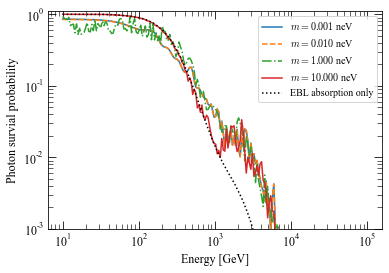

In [11]:
ls = ['-','--','-.']
for i,mi in enumerate(malp):
    plt.loglog(EGeV, px[i] + py[i], 
               label = '$m = {0:.3f}$ neV'.format(mi),
               ls = ls[i % len(ls)])
plt.loglog(m.EGeV, np.exp(-tau), label = 'EBL absorption only',
            color = 'k', ls = ':')
plt.legend()
plt.gca().set_ylim(1e-3,1.1)
plt.xlabel('Energy [GeV]')
plt.ylabel('Photon survial probability')

You notice that with increasing mass the oscillations are shifted towards higher energies as the critical energy increases. For the lowest two masses, the curves are identical. The reason is that the difference between the plasma frequency becomes very small (and the difference $|m_a^2 - \omega_\mathrm{pl}^2|$ is what enters the critical energy. This can be seen in the next plot:

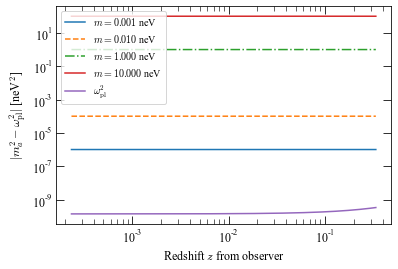

In [12]:
for i,mi in enumerate(malp):
    plt.loglog(m.modules[0]._zmean,mi**2 - transfer.w_pl_e9(m.modules[0].nel)**2.,
              label = '$m = {0:.3f}$ neV'.format(mi),ls = ls[i % len(ls)])
plt.loglog(m.modules[0]._zmean, transfer.w_pl_e9(m.modules[0].nel)**2.,
          label = '$\omega_\mathrm{pl}^2$')
plt.xlabel('Redshift $z$ from observer')
plt.ylabel('$|m_a^2 - \omega_\mathrm{pl}^2|$ [neV$^2$]')
plt.legend()